In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data

In [2]:
import torch
os.chdir("/content/drive/My Drive/ECEN758Project")

feature_path = './Data/Features/vit_b_16_features.pt'
data = torch.load(feature_path)
for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (60000, 768) (60000,)
Test Data (X, y):  (10000, 768) (10000,)


# Data Splitting

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data['train'][0], data['train'][1], test_size=5000, stratify=data['train'][1], random_state=10)
data['train'] = [X_train, y_train]
data['val'] = [X_val, y_val]

for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (55000, 768) (55000,)
Test Data (X, y):  (10000, 768) (10000,)
Val Data (X, y):  (5000, 768) (5000,)


# Data Transformation

## PCA

In [4]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
scalar = StandardScaler().fit(data['train'][0])
pca.fit(scalar.transform(data['train'][0]))
explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

data['train'][0] = pca.transform(scalar.transform(data['train'][0]))
data['val'][0] = pca.transform(scalar.transform(data['val'][0]))
data['test'][0] = pca.transform(scalar.transform(data['test'][0]))

## Normalization

In [5]:
scalar = StandardScaler().fit(*data['train'])

data['train'][0] = scalar.transform(data['train'][0])
data['val'][0] = scalar.transform(data['val'][0])
data['test'][0] = scalar.transform(data['test'][0])

## Anova Test

In [6]:
from sklearn.feature_selection import f_classif

scores, _ = f_classif(*data['train'])

feature_score = list(zip(range(0, data['train'][0].shape[1]), scores))
feature_score = sorted(feature_score, key=lambda item: item[1], reverse=True)

feature_ordering = [item[0] for item in feature_score]

data['train'][0] = data['train'][0][:, feature_ordering]
data['val'][0] = data['val'][0][:, feature_ordering]
data['test'][0] = data['test'][0][:, feature_ordering]

explained_variance_ratios = np.cumsum(
    pca.explained_variance_ratio_[feature_ordering])

## Feature Subset

In [7]:
n_component = 278

# SVM

100%|██████████| 1/1 [2:16:38<00:00, 8198.13s/it]


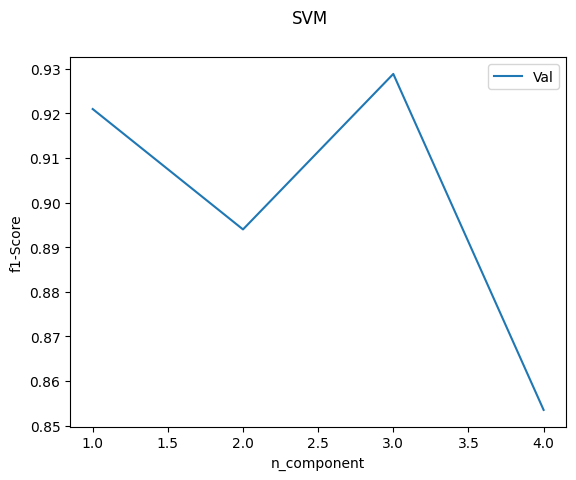

Maximum Validation F1-Score:  0.9288513972340194
Best model index: 2


In [8]:
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# from sklearn.model_selection import GridSearchCV, PredefinedSplit
np.random.seed(10)

val_f1_scores = []
for C in tqdm([0.1, 1, 10, 25]):

    for k in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):

        if k == 'poly':
          for degree in [2, 3 ,4]:
              clf = SVC(C = C, kernel = k, degree = degree).fit(data['train'][0][:,:n_component], data['train'][1])
              val_preds = clf.predict(data['val'][0][:,:n_component])
              s = f1_score(data['val'][1], val_preds, average='macro')
              val_f1_scores.append(s)
              torch.save(clf, './Data/Models/HP_SVM_C'+str(C)+'_k_poly_d'+str(degree)+'_f1score_'+str(round(s,4))+'.pt')

        else:
              clf = SVC(C = C, kernel = k).fit(data['train'][0][:,:n_component], data['train'][1])
              val_preds = clf.predict(data['val'][0][:,:n_component])
              s = f1_score(data['val'][1], val_preds, average='macro')
              val_f1_scores.append(s)
              torch.save(clf, './Data/Models/HP_SVM_C'+str(C)+'_k_'+k+'_f1score_'+str(round(s,4))+'.pt')

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('SVM')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))
print('Best model index:', np.argmax(val_f1_scores))